# IMA205 Challenge 2025
## Joel Cabrera (gochanson)

IMPORTANT: You should have the zip on the same folder OR the Dataset folder.

In [ ]:
import zipfile
import os

zip_path = 'ima-205-challenge-2025.zip'
extract_to = '.'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Success.")

In [33]:
! pip install seaborn scikit-image scikit-learn pandas torchio numpy nibabel matplotlib regex xgboost

# 1. Context

The goal of this challenge is to classify subjects based on their cardiac magnetic resonance imaging (CMRI) scans into one of five diagnostic categories:
- Healthy controls
- Myocardial infarction
- Dilated cardiomyopathy
- Hypertrophic cardiomyopathy
- Abnormal right ventricle


These categories reflect a variety of structural and functional heart conditions that can be differentiated through careful analysis of cardiac morphology and function as captured in CMRI data.

To tackle this classification task, we first aim to extract a set of meaningful features from the medical images. These features are designed to reflect relevant physiological properties such as ventricular volumes, myocardial thickness, and ejection fractions. Once extracted, these features will serve as input to various machine learning models, including Random Forests, XGBoost, Support Vector Machines, and Logistic Regression, to predict the corresponding class label.

This pipeline emulates a clinically-inspired approach, where diagnostic decisions rely on interpretable and quantifiable markers derived from imaging, while leveraging the predictive power of modern machine learning classifiers.

In [14]:
import torchio as tio
import numpy as np
import nibabel as nib
from matplotlib import pyplot as plt
import regex as re
import pandas as pd
from pathlib import Path

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1.1. Load the data

Some NIfTI files contain an sform matrix with scaling or orientation metadata that does not match the voxel dimensions (pixdim or zooms) specified in the header. To avoid these warnings and ensure spatial consistency across all images, we reconstruct the affine transformation matrix from the voxel sizes. It ensures that all loaded subjects are spatially aligned and safely interpreted by TorchIO and other libraries.


In [70]:
def normalize_min_max(image):
    data = image.data
    min_val = data.min()
    max_val = data.max()
    if max_val > min_val:
        data = (data - min_val) / (max_val - min_val)
    else:
        data = torch.zeros_like(data)
    image.set_data(data)
    return image


def load_scalar_image_fixed(path):
    img = nib.load(str(path))
    data = img.get_fdata().astype(np.float32) 
    zooms = img.header.get_zooms()

    #create corrected affine
    affine = np.diag(zooms + (1.0,))

    data_tensor = torch.from_numpy(data).unsqueeze(0)  #channel dim

    return tio.ScalarImage(tensor=data_tensor, affine=affine)

def load_labelmap_fixed(path):
    img = nib.load(str(path))
    data = img.get_fdata().astype(np.int16) 
    zooms = img.header.get_zooms()
    affine = np.diag(zooms + (1.0,))
    data_tensor = torch.from_numpy(data).unsqueeze(0)  # (1, H, W, D)
    return tio.LabelMap(tensor=data_tensor, affine=affine)


def load_data(path):
    subjects = []

    for subject_dir in sorted(Path(path).iterdir()):
        if subject_dir.is_dir():
            if int(subject_dir.name) % 10 == 0:
                print('Loading subject:', subject_dir.name)
            
            ED = normalize_min_max(load_scalar_image_fixed(subject_dir / f'{subject_dir.name}_ED.nii'))
            ES = normalize_min_max(load_scalar_image_fixed(subject_dir / f'{subject_dir.name}_ES.nii'))
            ED_seg = load_labelmap_fixed(subject_dir / f'{subject_dir.name}_ED_seg.nii')
            ES_seg = load_labelmap_fixed(subject_dir / f'{subject_dir.name}_ES_seg.nii')

            subject = tio.Subject(
                ED=ED,
                ES=ES,
                ED_seg=ED_seg,
                ES_seg=ES_seg
            )

            subjects.append(subject)

    dataset = tio.SubjectsDataset(subjects)
    print('Dataset size:', len(dataset), 'subjects')

    return dataset

def categorization_accuracy(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    y_true = np.argmax(y_true, axis=1)
    y_pred = np.argmax(y_pred, axis=1)
    return np.mean(y_true == y_pred)

In [71]:
train_data_path = 'Dataset/Train'
train_data = load_data(train_data_path)


test_data_path = 'Dataset/Test'
test_data = load_data(test_data_path)


train_metadata_path = 'Dataset/metaDataTrain.csv'
test_metadata_path = 'Dataset/metaDataTest.csv'

test_labels = []

train_metadata = pd.read_csv(train_metadata_path).set_index('Id')
test_metadata = pd.read_csv(test_metadata_path).set_index('Id')




Loading subject: 010
Loading subject: 020
Loading subject: 030
Loading subject: 040
Loading subject: 050
Loading subject: 060
Loading subject: 070
Loading subject: 080
Loading subject: 090
Loading subject: 100
Dataset size: 100 subjects
Loading subject: 110
Loading subject: 120
Loading subject: 130
Loading subject: 140
Loading subject: 150
Dataset size: 50 subjects


# 2. Segmentation

In this section, we detail the method implemented for segmenting the left ventricle (LV), which is critical for extracting robust features.

Unlike more complex methodologies such as iterative thresholding for endocardial contour extraction or active contour models (ACM or snakes) for epicardial contour extraction, described in [1], our method simplifies significantly by directly leveraging provided myocardium segmentation masks.

## 2.1 Segmentation steps

The simplified segmentation process involves the following sequential steps:
1. **Myocardium Mask Utilization**: Directly use the provided myocardium segmentation mask.
2. **Convex Hull Computation**: Compute a convex hull around the myocardium to define a smooth enclosed region.
3. **Myocardium Exclusion**: Subtract the myocardium region from its convex hull, effectively isolating the LV cavity.
4. **Connected Component Filtering**: Retain only the largest connected component to ensure anatomical continuity.
5. **Hole Filling and Final Convex Hull**: Apply morphological operations to fill internal holes, followed by a final convex hull to yield a clean and anatomically plausible LV mask.

It is pertinent to mention that this is easily computable due to the availability of the segmentation of the myocardium. In other contexts, we should have applied more complex methodologies such as iterative thresholding, region-growing based on intensity, among others. Our approach provides a simpler, computationally efficient, and robust alternative.

In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image
from scipy.ndimage import label, binary_fill_holes
from sklearn.base import BaseEstimator, TransformerMixin

class LVSegmenter(BaseEstimator, TransformerMixin):
    def __init__(self, plot=False):
        self.plot = plot

    def fit(self, X, y=None):
        return self

    def predict(self, subject):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        for attr in ['ED', 'ES', 'ED_seg', 'ES_seg']:
            getattr(subject, attr).set_data(getattr(subject, attr).data.to(device))

        ed_img = subject.ED.data.cpu().numpy()
        es_img = subject.ES.data.cpu().numpy()
        ed_seg = subject.ED_seg.data.cpu().numpy()
        es_seg = subject.ES_seg.data.cpu().numpy()

        depth, height, width = ed_seg[0].shape
        masks = np.zeros((2, depth, height, width))
        volume_sum = np.array([0, 0])

        for phase_index, (img_phase, seg_phase) in enumerate([(ed_img, ed_seg), (es_img, es_seg)]):
            for slice_index in range(img_phase.shape[3]):
                image = img_phase[0, :, :, slice_index]
                seg = seg_phase[0, :, :, slice_index]
                myocardium_mask = (seg == 2)

                if np.sum(myocardium_mask) == 0:
                    continue  # skip slice, nothing to segment

                

                try:
                    region = convex_hull_image(myocardium_mask)
                    region &= ~myocardium_mask
                    region = self._keep_connected_component(region)
                    region = binary_fill_holes(region)
                    region = convex_hull_image(region) & ~myocardium_mask
                except Exception:
                    continue

                volume = np.sum(region)
                if volume < 5 or volume > 10000:
                    volume = 5

                if self.plot:
                    print(f"Slice {slice_index}) Volume: {int(volume)}")
                    plt.imshow(image, cmap='gray')
                    plt.title(f"LV Segmentation: Slice {slice_index}")
                    plt.imshow(region, cmap='jet', alpha=0.8)
                    plt.imshow(seg, cmap='gray', alpha=0.3)
                    plt.axis('off')
                    plt.show()

                masks[phase_index, :, :, slice_index] = region
                volume_sum[phase_index] += volume

        return masks, volume_sum

    def _keep_connected_component(self, region):
        labeled, _ = label(region)
        if labeled.max() == 0:
            return np.zeros_like(region)
        # Keep the largest component
        largest = np.argmax(np.bincount(labeled.flat)[1:]) + 1
        return labeled == largest


Slice 0) Volume: 1263


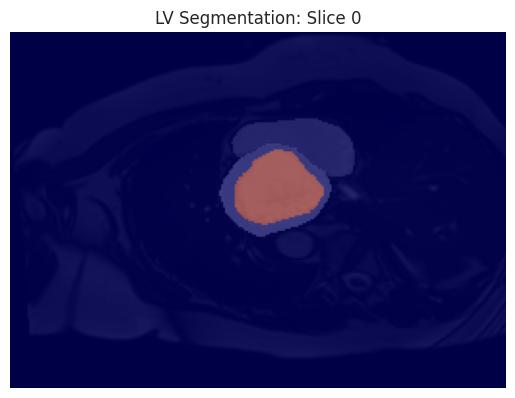

Slice 1) Volume: 1504


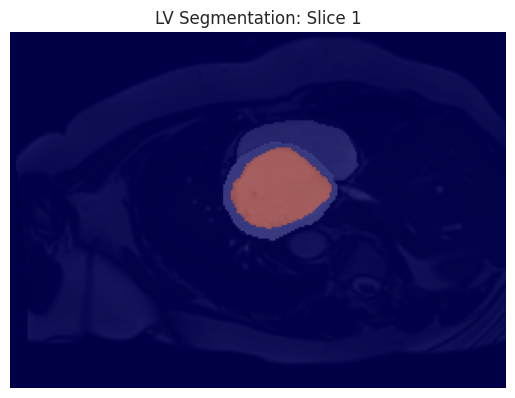

Slice 2) Volume: 1668


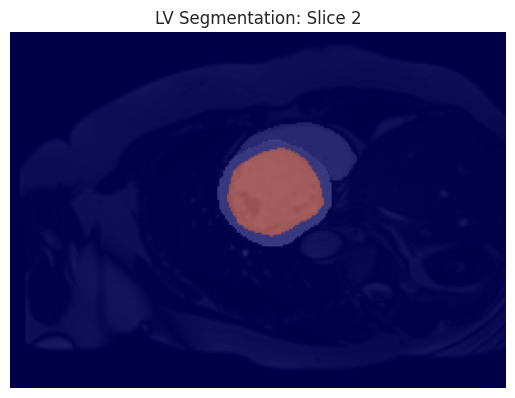

Slice 3) Volume: 1702


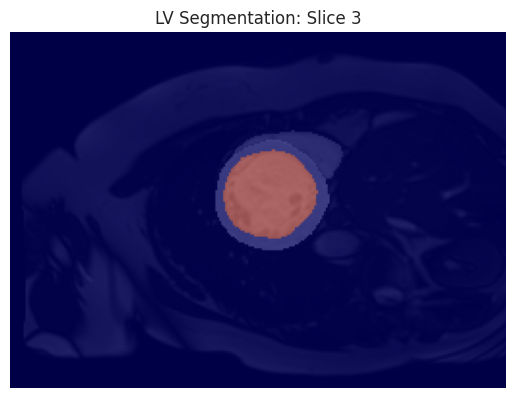

Slice 4) Volume: 1626


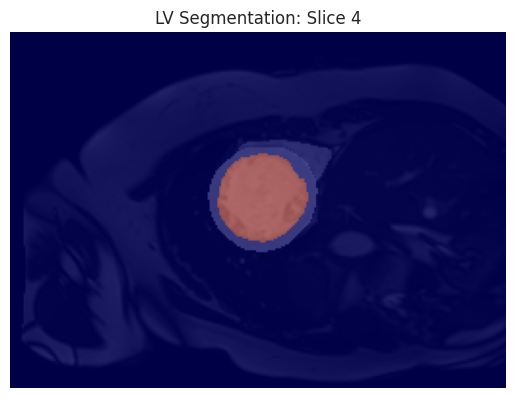

Slice 5) Volume: 1472


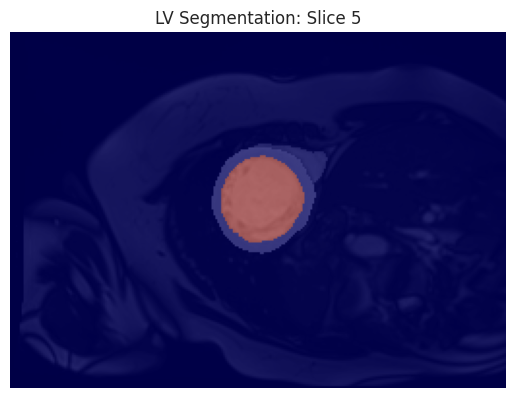

Slice 6) Volume: 1275


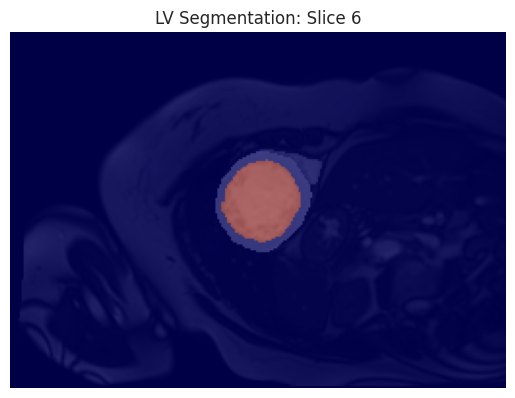

Slice 7) Volume: 1015


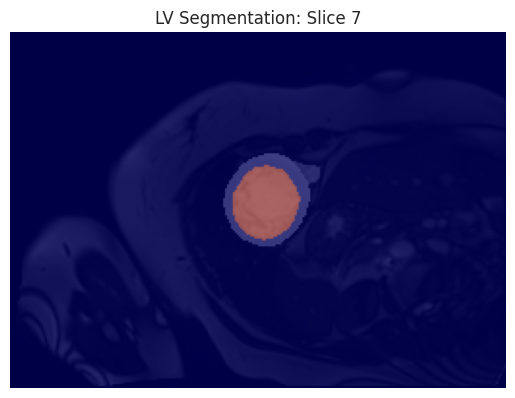

Slice 8) Volume: 710


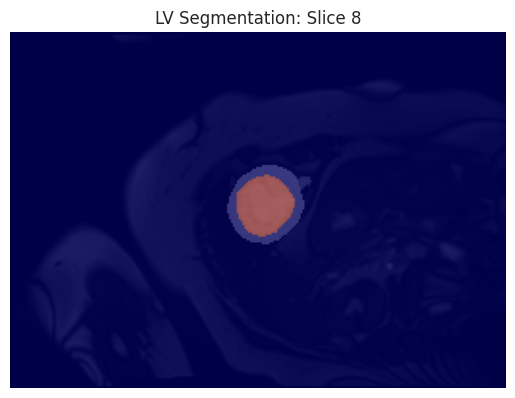

Slice 9) Volume: 409


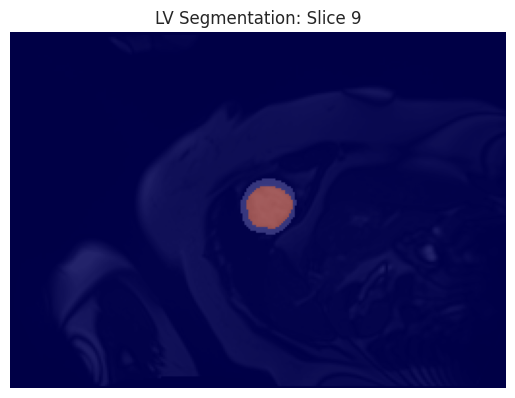

Slice 1) Volume: 1006


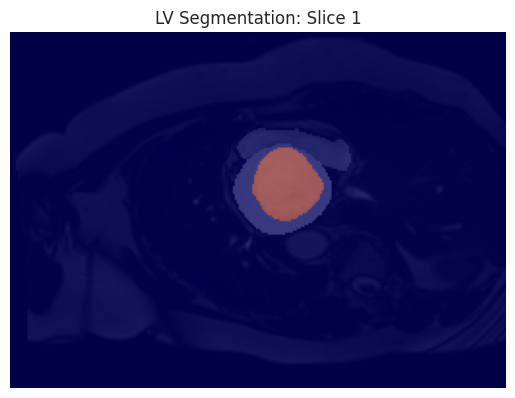

Slice 2) Volume: 1379


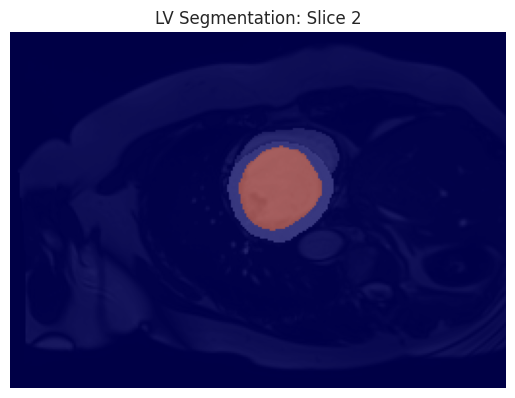

Slice 3) Volume: 1539


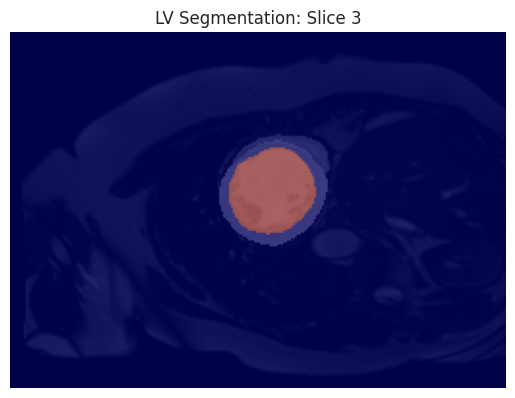

Slice 4) Volume: 1523


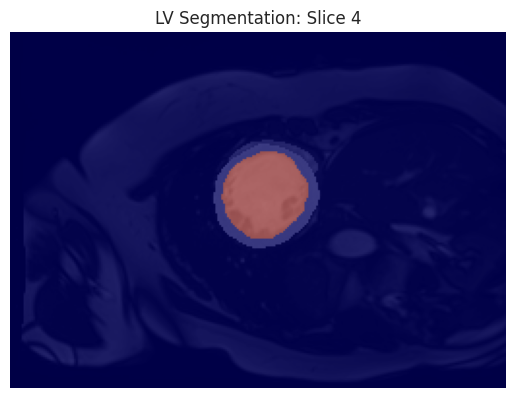

Slice 5) Volume: 1328


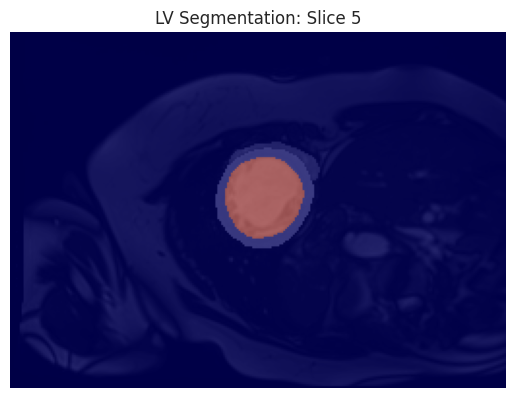

Slice 6) Volume: 1171


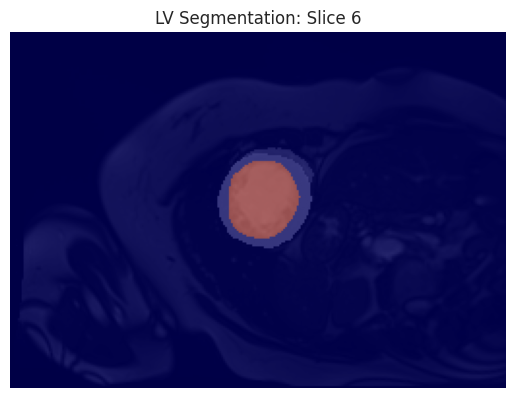

Slice 7) Volume: 860


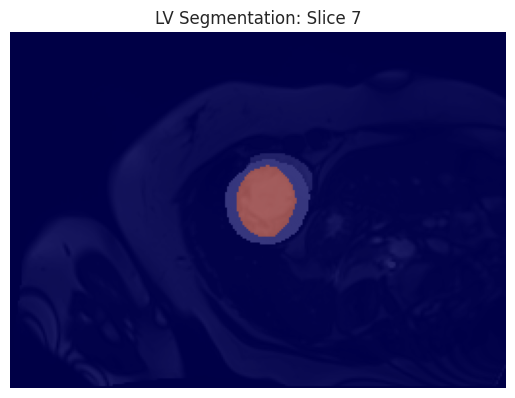

Slice 8) Volume: 536


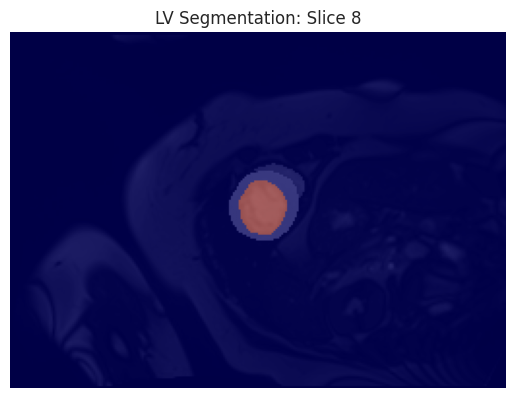

Slice 9) Volume: 213


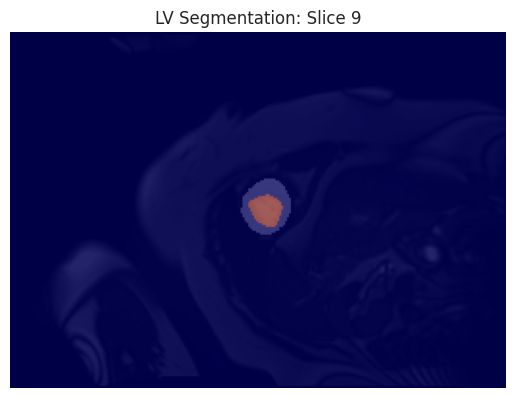

LV Volume: [12644  9555]


In [73]:
#example usage
subject = train_data[11]
segmenter = LVSegmenter(plot=True)
masks, vol = segmenter.predict(subject)
print('LV Volume:', vol)

In [74]:
y_train = train_metadata['Category'].values
print('Train labels:', y_train)


Train labels: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


Figure saved at: lv_segmentation_steps.png


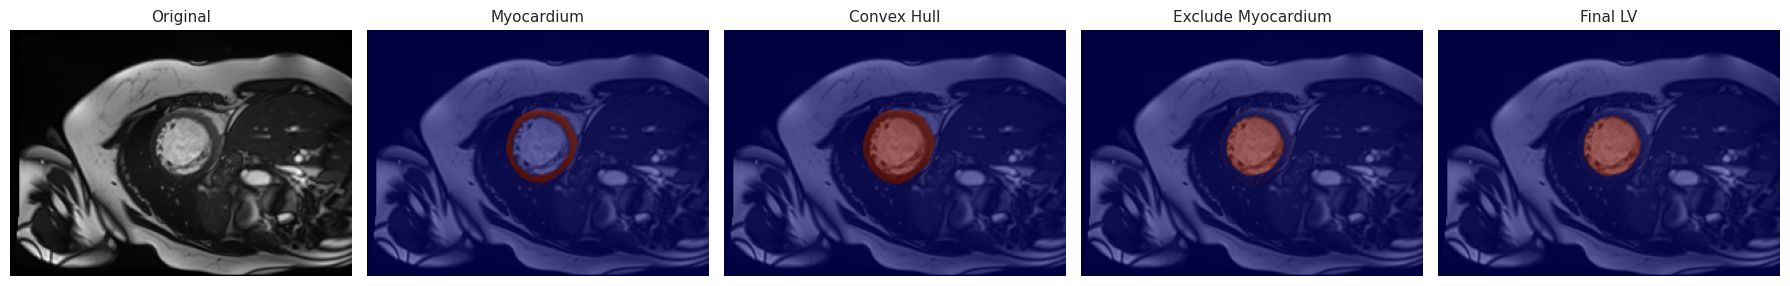

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import convex_hull_image
from scipy.ndimage import binary_fill_holes, label

def plot_lv_segmentation_steps_row(img_slice, seg_slice, slice_idx=None, save_path=None):
    """
    Plot the full simplified LV segmentation pipeline as a horizontal figure (1x5).
    """
    
    plt.style.use('seaborn-v0_8-white')

    myocardium_mask = (seg_slice == 2)

    #original image
    original = img_slice

    #myocardium overlay
    step1 = myocardium_mask

    #convex hull
    step2 = convex_hull_image(myocardium_mask)

    #exclude myocardium
    step3 = step2 & ~myocardium_mask

    #final LV mask (largest comp + fill + convex hull)
    labeled, _ = label(step3)
    if labeled.max() == 0:
        step4 = np.zeros_like(step3)
    else:
        largest = np.argmax(np.bincount(labeled.flat)[1:]) + 1
        step4 = labeled == largest
    step4 = binary_fill_holes(step4)
    step5 = convex_hull_image(step4) & ~myocardium_mask

    steps = [
        ("Original", original, None),
        ("Myocardium", original, step1),
        ("Convex Hull", original, step2),
        ("Exclude Myocardium", original, step3),
        ("Final LV", original, step5)
    ]

    fig, axes = plt.subplots(1, len(steps), figsize=(18, 4))
    for ax, (title, base, overlay) in zip(axes, steps):
        ax.imshow(base, cmap='gray')
        if overlay is not None:
            ax.imshow(overlay, cmap='jet', alpha=0.5)
        ax.set_title(title, fontsize=11)
        ax.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
        print(f"Figure saved at: {save_path}")
    else:
        plt.show()

subject = train_data[11]
slice_idx = 5
img = subject.ED.data.cpu().numpy()[0][:, :, slice_idx]
seg = subject.ED_seg.data.cpu().numpy()[0][:, :, slice_idx]
plot_lv_segmentation_steps_row(img, seg, slice_idx=slice_idx, save_path="lv_segmentation_steps.png")

## 2.2. Evaluation of LV Segmentation Accuracy

To evaluate the performance of our proposed left ventricle (LV) segmentation method, we computed the Dice similarity coefficient (DSC) on the training set, where full ground truth annotations are available. The Dice score is defined as:

$DSC = \frac{2|P \cap G|}{|P|+|G|}$
where P is the predicted LV mask and G is the ground truth mask (label 3 in our dataset).

Importantly, our method assumes that a segmentation of the myocardium (label 2) is available, which is consistent with the information provided at test time. Thus, the evaluation measures how well the LV cavity can be reconstructed from the myocardium mask alone, without relying on image intensities or learned models.


In [76]:
def dice_score(pred, target):
    """
    Computes the Dice coefficient between two binary masks.
    """
    pred = pred.astype(bool)
    target = target.astype(bool)
    intersection = np.logical_and(pred, target).sum()
    return 2 * intersection / (pred.sum() + target.sum() + 1e-8)


dice_scores = []
segmenter.plot = False  # disable plotting for evaluation

for subject in train_data:
    pred_masks, _ = segmenter.predict(subject)

    #ground truth LV mask (label == 3)
    gt_ed = (subject.ED_seg.data.cpu().numpy()[0] == 3)
    gt_es = (subject.ES_seg.data.cpu().numpy()[0] == 3)

    pred_ed = pred_masks[0]
    pred_es = pred_masks[1]

    #evaluate per slice only where GT is non-empty
    for pred, gt in zip(pred_ed, gt_ed):
        if gt.sum() == 0:
            continue
        score = dice_score(pred, gt)
        dice_scores.append(score)

    for pred, gt in zip(pred_es, gt_es):
        if gt.sum() == 0:
            continue
        dice_scores.append(dice_score(pred, gt))
        

mean_dice = np.mean(dice_scores)
print(f"Evaluated {len(dice_scores)} slices.")

print(f"Mean Dice score across train set: {mean_dice:.2f}")


Evaluated 7600 slices.
Mean Dice score across train set: 1.00


# 3. Classification

The selected features for classification encompass both functional and anatomical cardiac descriptors. These include end-diastolic and end-systolic volumes for the left and right ventricular cavities (LVC_ED_Volume, LVC_ES_Volume, RVC_ED_Volume, RVC_ES_Volume), as well as the left and right ejection fractions (Ejection_Fraction_Left, Ejection_Fraction_Right). These variables are core indicators of ventricular performance and are widely used in clinical practice to assess contractility and diagnose heart failure [2, 3, 4].

In addition, we included myocardial thickness at both ED and ES phases (Myocardium_Thickness_ED, Myocardium_Thickness_ES) as structural features. Patient-specific factors such as height and weight were also included.

In [77]:
# 0 - Background
# 1 - Right ventricle cavity
# 2 - Myocardium
# 3 - Left ventricle cavity

def get_RVC(subject):
    ed_seg = subject['ED_seg'].data.cpu().numpy()
    es_seg = subject['ES_seg'].data.cpu().numpy()

    rvc_ed = (ed_seg == 1).astype(np.float32) 
    rvc_es = (es_seg == 1).astype(np.float32)

    return rvc_ed, rvc_es

def get_LVC(subject, mask=None):
    if mask is None:
        ed_seg = subject['ED_seg'].data.cpu().numpy()
        es_seg = subject['ES_seg'].data.cpu().numpy()
    
        lvc_ed = (ed_seg == 3).astype(np.float32)
        lvc_es = (es_seg == 3).astype(np.float32)
    else:
        mask_ed = mask[0, :, :, :]
        mask_es = mask[1, :, :, :]
        lvc_ed = (mask_ed > 0).astype(np.float32) 
        lvc_es = (mask_es > 0).astype(np.float32)
    
    return lvc_ed, lvc_es

def get_Myo(subject):
    ed_seg = subject['ED_seg'].data.cpu().numpy()
    es_seg = subject['ES_seg'].data.cpu().numpy()
    ed = subject['ED'].data.cpu().numpy()
    es = subject['ES'].data.cpu().numpy()

    myo_ed = np.zeros(ed.shape)
    myo_es = np.zeros(ed.shape)

    myo_ed[ed_seg == 2] = ed[ed_seg == 2]
    myo_es[es_seg == 2] = es[es_seg == 2]

    return myo_ed, myo_es

def get_ejection_fraction(subject, mask=None):
    #first we need to get the volume of the left ventricle at ED and ES
    #we can use the function get_LVC to get the left ventricle cavity
    lvc_ed, lvc_es = get_LVC(subject,mask)
    #the volume is the sum of the pixels in the left ventricle cavity
    lvc_ed_volume = np.sum(lvc_ed) * np.prod(subject['ED'].spacing)
    lvc_es_volume = np.sum(lvc_es) * np.prod(subject['ES'].spacing)

    #the ejection fraction is the volume at ED minus the volume at ES divided by the volume at ED
    if lvc_ed_volume >0:
      ejection_fraction_left = (lvc_ed_volume - lvc_es_volume) / lvc_ed_volume
    else:
      ejection_fraction_left = 0

    rvc_ed, rvc_es = get_RVC(subject)
    rvc_ed_volume = np.sum(rvc_ed) * np.prod(subject['ED'].spacing)
    rvc_es_volume = np.sum(rvc_es) * np.prod(subject['ES'].spacing)

    ejection_fraction_right = (rvc_ed_volume - rvc_es_volume) / rvc_ed_volume

    return ejection_fraction_left, ejection_fraction_right

In [78]:
from scipy.ndimage import distance_transform_edt
def get_thickness_myo(subject):
    ed_seg = np.squeeze(subject['ED_seg'].data.cpu().numpy())
    es_seg = np.squeeze(subject['ES_seg'].data.cpu().numpy())

    #we get the myocardium
    myo_ed = (ed_seg == 2)
    myo_es = (es_seg == 2)

    #compute the thickness of myocardium using normal distance
    thickness_myo_ed = distance_transform_edt(myo_ed) + distance_transform_edt(~myo_ed)
    thickness_myo_es = distance_transform_edt(myo_es) + distance_transform_edt(~myo_es)

    thickness_myo_ed = thickness_myo_ed[myo_ed]
    thickness_myo_es = thickness_myo_es[myo_es]

    #compute mean thck
    try:
        avg_thickness_ed = np.mean(thickness_myo_ed)
        avg_thickness_es = np.mean(thickness_myo_es)
    except:
        return 0, 0

    return avg_thickness_ed, avg_thickness_es



In [79]:
def get_volume(subject,mask=None,is_test=False):
    if not is_test or mask is not None:
        lvc_ed, lvc_es = get_LVC(subject,mask)
        
        lvc_ed_volume = np.sum(lvc_ed)
        lvc_es_volume = np.sum(lvc_es)
    else:
        lvc_ed_volume = 'NaN'
        lvc_es_volume = 'NaN'

    rvc_ed, rvc_es = get_RVC(subject)
    rvc_ed_volume = np.sum(rvc_ed)
    rvc_es_volume = np.sum(rvc_es)

    return lvc_ed_volume, lvc_es_volume, rvc_ed_volume, rvc_es_volume


In [80]:
def get_height_weight(id,is_train=True):
    if is_train:
        return train_metadata.loc[id]['Height'], train_metadata.loc[id]['Weight']

    return test_metadata.loc[id]['Height'], test_metadata.loc[id]['Weight']

def get_category(id):
    return train_metadata.loc[id]['Category']

In [81]:
def get_features(subject,id,is_test=False,segmenter=None):
    masks = None
    if is_test:
        if segmenter is not None:
            masks, vol = segmenter.predict(subject)
        else:
            masks, vol = get_segmentations_lv(subject)  # fallback
        lvc_ed_volume, lvc_es_volume, rvc_ed_volume, rvc_es_volume = get_volume(subject, masks, True)
    else:
        lvc_ed_volume, lvc_es_volume, rvc_ed_volume, rvc_es_volume = get_volume(subject)


    thickness_myo_ed, thickness_myo_es = get_thickness_myo(subject)

    ef_left, ef_right = get_ejection_fraction(subject,masks)

    height, weight = get_height_weight(id)
    
    features = {
        'LVC_ED_Volume': lvc_ed_volume,
        'LVC_ES_Volume': lvc_es_volume,
        'RVC_ED_Volume': rvc_ed_volume,
        'RVC_ES_Volume': rvc_es_volume,
        'Myocardium_Thickness_ED': thickness_myo_ed,
        'Myocardium_Thickness_ES': thickness_myo_es,
        'Ejection_Fraction_Left': ef_left,
        'Ejection_Fraction_Right': ef_right,
        'Height': height,
        'Weight': weight,
    }

    return features


In [85]:
labels2 = [int(l) for l in labels]
print(labels2)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


In [98]:
import copy
transform = tio.Compose([
    #rot escale and translation
    tio.RandomAffine(
        scales=(0.6, 1.4),
        degrees=5,
        translation=(5, 5, 0)  # En mm
    ),

    #flip randomply hor or vert
    tio.RandomFlip(axes=('LR', 'AP'), flip_probability=0.5),

])

transform_original = tio.RescaleIntensity(out_min_max=(0, 1))


n_augment = 0
features = {}
labels = []
counter = 0

segmenter = LVSegmenter(plot=False)

N = len(train_data)
for i in range(N):
    subject = train_data[i]
    subject = transform_original(subject)

    lab = y_train[i]
    if id %15 ==0:
        print('Loading ',id,'/',N)
    id = i + 1
    

    # Original
    counter += 1
    features[counter] = get_features(subject, id,False, segmenter=segmenter)
    labels.append(lab)

    # Augment
    for _ in range(n_augment):
        subject.ED.set_data(subject.ED.data.cpu())
        subject.ES.set_data(subject.ES.data.cpu())
        subject.ED_seg.set_data(subject.ED_seg.data.cpu())
        subject.ES_seg.set_data(subject.ES_seg.data.cpu())

        subject_aug = transform(copy.deepcopy(subject))
        counter += 1
        try:
            features[counter] = get_features(subject_aug, id, False, segmenter=segmenter)
            labels.append(lab)
        except Exception as e:
            print(f"Error en augmentación {counter}: {e}")

print('Finished')

Loading  15 / 100
Loading  30 / 100
Loading  45 / 100
Loading  60 / 100
Loading  75 / 100
Loading  90 / 100
Finished


### Load test data

In [87]:
#test

test_transform = tio.Compose([
    tio.RescaleIntensity(out_min_max=(0, 1))
])


segmenter = LVSegmenter(plot=False)

features_test = {}
N = len(test_data)

for i in range(N):
    subject = test_data[i]
    id = i + 1

    if id % 10 == 0 or id == N:
        print(f'Subject {id}/{N}')

    try:
        #
        subject_norm = test_transform(copy.deepcopy(subject))
        features_test[id] = get_features(subject_norm, id, True, segmenter=segmenter)
    except Exception as e:
        print(f"Error en el subject {id}: {e}")

#start df by 1
features_test_df = pd.DataFrame.from_dict(features_test, orient='index')
#start by 1
print(features_test_df.head())

Subject 10/50
Subject 20/50
Subject 30/50
Subject 40/50
Subject 50/50
   LVC_ED_Volume  LVC_ES_Volume  RVC_ED_Volume  RVC_ES_Volume  \
1         4856.0         1343.0         5698.0         3034.0   
2         9701.0         3658.0        16473.0         8332.0   
3         5319.0         2010.0         6619.0         3619.0   
4         6304.0         1593.0         6177.0         2859.0   
5        12213.0        10632.0        11566.0         8024.0   

   Myocardium_Thickness_ED  Myocardium_Thickness_ES  Ejection_Fraction_Left  \
1                 1.210651                 1.596405                0.723435   
2                 1.149877                 1.342022                0.622925   
3                 1.321730                 1.553123                0.622109   
4                 1.276370                 1.443769                0.747303   
5                 1.121746                 1.146114                0.129452   

   Ejection_Fraction_Right  Height  Weight  
1                 0

## 3.1. Classifier Performance without Data Augmentation

In this experiment, we compare four classifiers: Random Forest, XGBoost, SVM and Logistic Regression. These classifiers were splitted on an 80 %/20 % train/validation of the raw feature set. Each model was tuned via 5-fold grid search over its hyper-parameters. Table 1 summarizes the selected parameters and the validation accuracies.


=== Random Forest ===
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Validation accuracy: 0.9000
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       0.80      1.00      0.89         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       0.75      0.75      0.75         4

    accuracy                           0.90        20
   macro avg       0.91      0.90      0.90        20
weighted avg       0.91      0.90      0.90        20


=== XGBoost ===
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
Validation accuracy: 0.9500
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00    

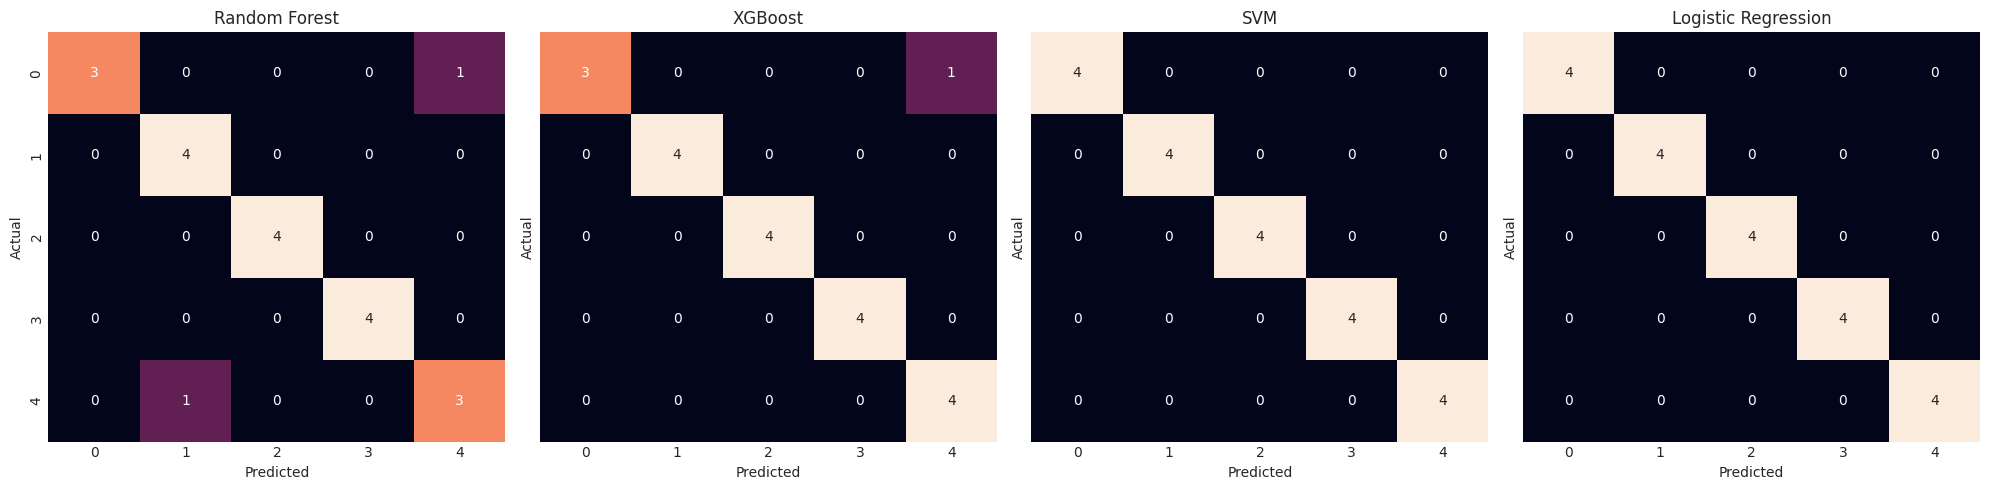

In [88]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.exceptions import ConvergenceWarning
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

# Suppress convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Prepare data
features_df = pd.DataFrame.from_dict(features, orient='index')
X = features_df.values
y = np.array(labels2)

# 80% train / 20% validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Class names in sorted order
class_names = np.unique(y_train)

# Define the classifiers and their hyperparameter grids
classifiers = {
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=42, eval_metric="logloss"),
        {
            "n_estimators": [100, 200],
            "max_depth": [2, 4],
            "learning_rate": [0.01, 0.1]
        }
    ),
    "SVM": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC(probability=True, random_state=42))
        ]),
        {
            "svc__C": [0.1, 1, 10],
            "svc__kernel": ["linear", "rbf"]
        }
    ),
    "Logistic Regression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
        ]),
        {
            "logreg__C": [0.1, 1, 10]
        }
    )
}

# Dictionary to store each classifier’s confusion matrix
confusion_matrices = {}

performance_summary = []

# Train, tune, and evaluate
for name, (model, param_grid) in classifiers.items():
    print(f"\n=== {name} ===")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)

    # Print best params, accuracy and classification report
    accuracy = np.mean(y_pred == y_val)
    print(f"Best parameters: {grid.best_params_}")
    print(f"Validation accuracy: {accuracy:.4f}")
    print("Classification report:")
    print(classification_report(y_val, y_pred))

    # Compute and store confusion matrix
    cm = confusion_matrix(y_val, y_pred, labels=class_names)
    confusion_matrices[name] = cm

    performance_summary.append({
        "model": name,
        "accuracy": accuracy,
        "params": grid.best_params_
    })

# Summary of performance
print("\nModel performance summary:")
for entry in performance_summary:
    print(f"- {entry['model']}: validation accuracy = {entry['accuracy']:.4f}, best parameters = {entry['params']}")

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        ax=ax
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(name)

plt.tight_layout()
plt.savefig("cm_no_aug.png", dpi=300, bbox_inches='tight')
plt.show()


## 3.2 Classifier perfomance with Data Augmentation

In [90]:
import copy
transform = tio.Compose([
    # Afinación: rotación, escala, traslación
    tio.RandomAffine(
        scales=(0.6, 1.4),
        degrees=5,
        translation=(5, 5, 0)  # En mm
    ),

    # Flip horizontal o vertical (al azar)
    tio.RandomFlip(axes=('LR', 'AP'), flip_probability=0.5),

])

y_train = train_metadata['Category'].values

n_augment = 5
features_augmented = {}
labels_augmented = []
counter = 0

segmenter = LVSegmenter(plot=False)
N = len(train_data)
for i in range(N):
    subject = train_data[i]

    lab = y_train[i]

    if id%15 == 0:
        print('Subject ',id,'/',N)

    id = i + 1
    # Original
    counter += 1
    features_augmented[counter] = get_features(subject, id,False, segmenter=segmenter)
    labels_augmented.append(lab)

    # Augmentaciones
    for _ in range(n_augment):
        subject.ED.set_data(subject.ED.data.cpu())
        subject.ES.set_data(subject.ES.data.cpu())
        subject.ED_seg.set_data(subject.ED_seg.data.cpu())
        subject.ES_seg.set_data(subject.ES_seg.data.cpu())

        subject_aug = transform(copy.deepcopy(subject))
        counter += 1
        try:
            features_augmented[counter] = get_features(subject_aug, id, False, segmenter=segmenter)
            labels_augmented.append(lab)
        except Exception as e:
            print(f"Error en augmentación {counter}: {e}")

print('Finished')

Subject  15 / 100
Subject  30 / 100
Subject  45 / 100
Subject  60 / 100
Subject  75 / 100
Subject  90 / 100


In [91]:
labels_augmented = [int(l) for l in labels_augmented]
print(labels_augmented)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 


=== Random Forest ===
Best parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Validation accuracy: 0.8833
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.92      0.83        24
           1       0.88      0.96      0.92        24
           2       1.00      0.96      0.98        24
           3       0.89      0.67      0.76        24
           4       0.92      0.92      0.92        24

    accuracy                           0.88       120
   macro avg       0.89      0.88      0.88       120
weighted avg       0.89      0.88      0.88       120


=== XGBoost ===
Best parameters: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 200}
Validation accuracy: 0.9500
Classification report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        24
           1       0.89      1.00      0.94        24
           2       1.00      0.96      0.98    

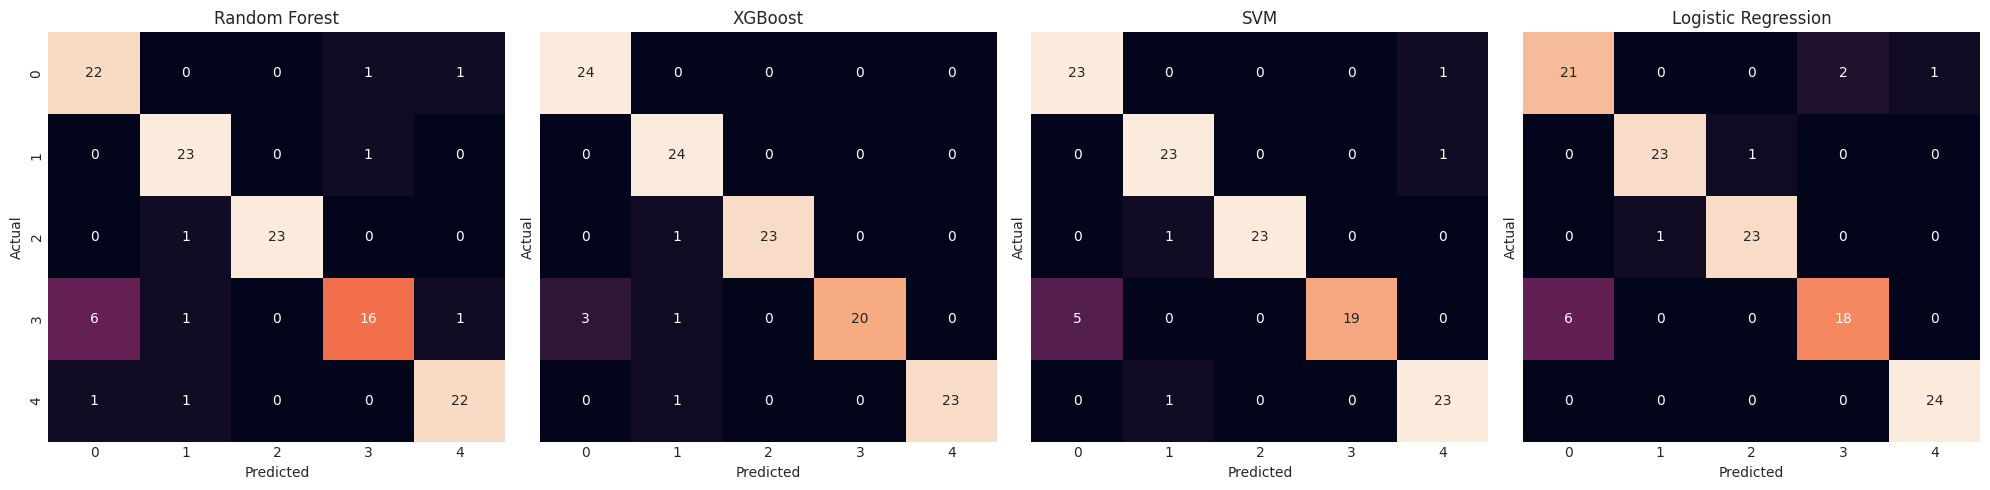

In [92]:
features_df_augmented = pd.DataFrame.from_dict(features_augmented, orient='index')
X = features_df_augmented.values
y = np.array(labels_augmented)

# 80% train / 20% validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

class_names = np.unique(y_train)

classifiers = {
    "Random Forest": (
        RandomForestClassifier(random_state=42),
        {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5]
        }
    ),
    "XGBoost": (
        XGBClassifier(random_state=42, eval_metric="logloss"),
        {
            "n_estimators": [100, 200],
            "max_depth": [2, 4],
            "learning_rate": [0.01, 0.1]
        }
    ),
    "SVM": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("svc", SVC(probability=True, random_state=42))
        ]),
        {
            "svc__C": [0.1, 1, 10],
            "svc__kernel": ["linear", "rbf"]
        }
    ),
    "Logistic Regression": (
        Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42))
        ]),
        {
            "logreg__C": [0.1, 1, 10]
        }
    )
}

performance_summary = []
confusion_matrices = {}

for name, (model, param_grid) in classifiers.items():
    print(f"\n=== {name} ===")
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring="accuracy",
        n_jobs=-1
    )
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_val)

    accuracy = np.mean(y_pred == y_val)
    print(f"Best parameters: {grid.best_params_}")
    print(f"Validation accuracy: {accuracy:.4f}")
    print("Classification report:")
    print(classification_report(y_val, y_pred))

    cm = confusion_matrix(y_val, y_pred, labels=class_names)
    confusion_matrices[name] = cm

    performance_summary.append({
        "model": name,
        "accuracy": accuracy,
        "params": grid.best_params_
    })

print("\nModel performance summary:")
for entry in performance_summary:
    print(f"- {entry['model']}: validation accuracy = {entry['accuracy']:.4f}, best parameters = {entry['params']}")

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=False,
        ax=ax
    )
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(name)

plt.tight_layout()
plt.savefig("cm_aug.png", dpi=300, bbox_inches='tight')
plt.show()

#### Using XGBoost to predict

In [93]:
from xgboost import XGBClassifier

best_xgb = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.1,
    eval_metric="logloss",
    random_state=42
)

best_xgb.fit(X_train, y_train)

X_test = features_test_df
X_test2 = X_test.copy()

y_test = best_xgb.predict(X_test2)
print(y_test)


[0 4 0 3 2 1 4 2 1 0 3 2 1 3 3 1 4 4 4 2 0 1 0 1 3 2 4 0 3 0 0 1 2 0 1 3 3
 2 0 3 1 1 0 0 1 4 2 4 1 4]


#### Using SVM to predict

In [94]:
svm_best = Pipeline([
    ("scaler", StandardScaler()),
    ("svc",    SVC(C=10,
                   kernel="rbf",
                   probability=True,
                   random_state=42))
])

svm_best.fit(X_train, y_train)

y_val_pred = svm_best.predict(X_val)
val_accuracy = np.mean(y_val_pred == y_val)
print(f"Validation accuracy: {val_accuracy:.4f}")

y_test = svm_best.predict(X_test2)
print(y_test)


Validation accuracy: 0.9250
[0 4 0 3 2 1 0 2 2 0 0 2 1 4 3 1 4 4 4 1 0 0 0 1 3 2 4 0 3 0 0 3 2 3 2 3 0
 2 0 3 1 1 3 0 1 4 2 0 1 4]


/usr/local/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## 3.3. Features importance

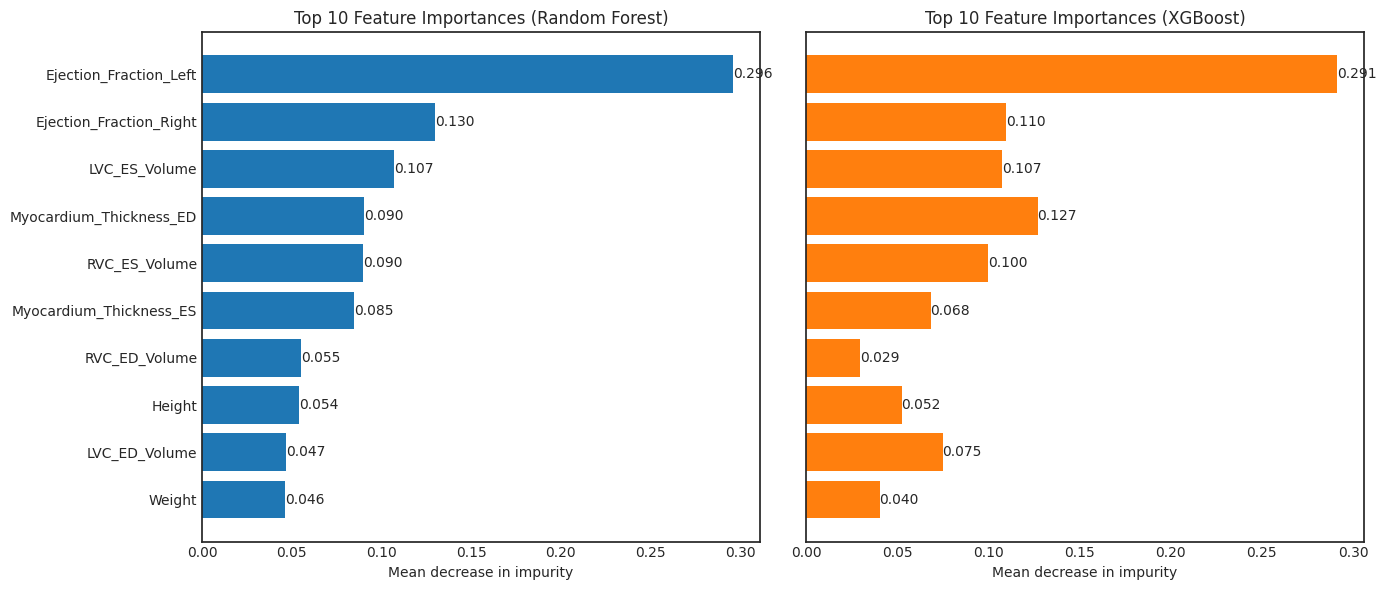

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize

features_df = pd.DataFrame.from_dict(features, orient='index')  # your dict → DataFrame
X = features_df_augmented.values
y = np.array(labels_augmented)

# 80/20 split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#trian both models ######
rf = RandomForestClassifier(n_estimators=200, max_depth=None,
                            min_samples_split=2, random_state=42)
xgb = XGBClassifier(n_estimators=200, max_depth=2,
                    learning_rate=0.1, random_state=42,
                    eval_metric='logloss')

rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

feature_names = features_df_augmented.columns

importances_rf = rf.feature_importances_
importances_xgb = xgb.feature_importances_

feat_imp_df_rf = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances_rf
    })
    .sort_values('importance', ascending=False)
    .head(10)
)

feat_imp_df_xgb = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances_xgb
    })
    .sort_values('importance', ascending=False)
    .head(10)
)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

bars_rf = axes[0].barh(feat_imp_df_rf['feature'][::-1], feat_imp_df_rf['importance'][::-1])
axes[0].set_xlabel('Mean decrease in impurity')
axes[0].set_title('Top 10 Feature Importances (Random Forest)')
axes[0].bar_label(bars_rf, fmt='%.3f')

bars_xgb = axes[1].barh(feat_imp_df_xgb['feature'][::-1], feat_imp_df_xgb['importance'][::-1], color='tab:orange')
axes[1].set_xlabel('Mean decrease in impurity')
axes[1].set_title('Top 10 Feature Importances (XGBoost)')
axes[1].bar_label(bars_xgb, fmt='%.3f')

plt.tight_layout()
plt.savefig("feature_importances_rf_xgb.png", dpi=300, bbox_inches='tight')
plt.show()



## 3.4. Classifier Decision Boundaries in PCA Space

To better understand how each classifier separates the classes in feature space, we projected the data onto the first two principal components and visualized the decision boundaries of the four main models used in our study.

The decision surfaces show distinct patterns: Random Forest and XGBoost produce non-linear, axis-aligned partitions; SVM defines smooth non-linear boundaries; and Logistic Regression results in linear separation. These visualizations qualitatively support the numerical performance metrics presented earlier, highlighting the consistency between the learned decision boundaries and the underlying class structure.

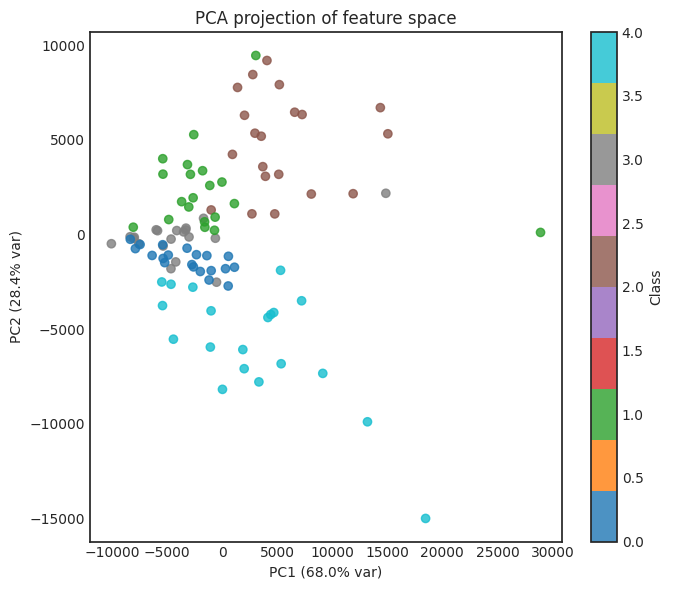

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert dict to DataFrame if needed
features_df = pd.DataFrame.from_dict(features, orient='index')  # o features_augmented
X = features_df.values
y = np.array(labels2)  # o labels_augmented

# --- PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# --- Plot ---
plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', alpha=0.8)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')
plt.title('PCA projection of feature space')
plt.colorbar(scatter, label='Class')
plt.tight_layout()
plt.savefig("pca_proj.png", dpi=300, bbox_inches='tight')

plt.show()


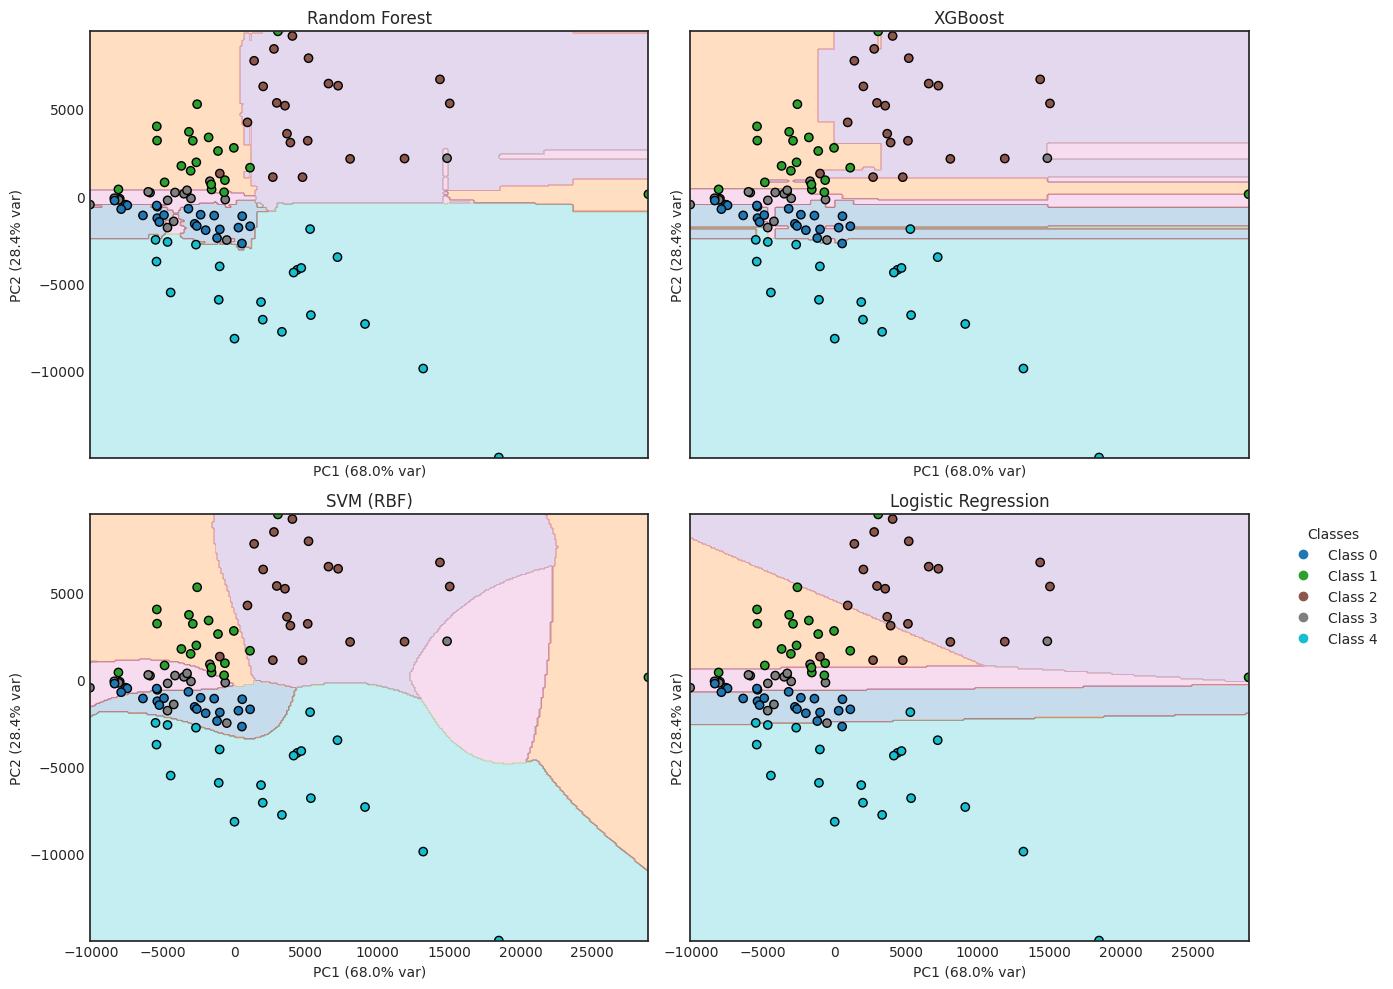

In [97]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

X = features_df.values
y = np.array(labels2) 


# Apply PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

clf_rf = RandomForestClassifier(n_estimators=200, max_depth=None,
                                min_samples_split=2, random_state=42)
clf_xgb = XGBClassifier(n_estimators=200, max_depth=4,
                        learning_rate=0.1,
                        eval_metric='mlogloss', random_state=42)
clf_svm = SVC(C=10, kernel='rbf', probability=True, random_state=42)
clf_log = LogisticRegression(C=10, solver='lbfgs', max_iter=1000, random_state=42)

# Fit all models to the PCA-projected data
clf_rf.fit(X_pca, y)
clf_xgb.fit(X_pca, y)
clf_svm.fit(X_pca, y)
clf_log.fit(X_pca, y)

#create meshgrid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

#predict for each model on that grid
Z_rf = clf_rf.predict(grid).reshape(xx.shape)
Z_xgb = clf_xgb.predict(grid).reshape(xx.shape)
Z_svm = clf_svm.predict(grid).reshape(xx.shape)
Z_log = clf_log.predict(grid).reshape(xx.shape)

#plot decision bound.
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=True)
titles = ['Random Forest', 'XGBoost', 'SVM (RBF)', 'Logistic Regression']
Zs = [Z_rf, Z_xgb, Z_svm, Z_log]
clfs = [clf_rf, clf_xgb, clf_svm, clf_log]

for ax, Z, title in zip(axes.flat, Zs, titles):
    ax.contourf(xx, yy, Z, alpha=0.25, cmap='tab10')
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='tab10', edgecolor='k')
    ax.set_title(title)
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)')


handles = scatter.legend_elements()[0]
labels = [f"Class {i}" for i in np.unique(y)]
axes[1, 1].legend(handles, labels, title="Classes", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig("pca_proj_clas.png", dpi=300, bbox_inches='tight')

plt.show()


## 5. Conclusion

In this work, we developed a segmentation-based pipeline for classifying cardiac pathologies from CMRI images. By combining geometric and functional features extracted from the segmented left and right ventricles and myocardium, we trained several supervised classifiers and achieved high validation performance. Among the tested models, XGBoost and SVM showed the most consistent results, both with and without data augmentation.

Beyond accuracy, we emphasized feature interpretability and anatomical relevance. Features such as ejection fraction, ventricular volumes, and myocardial thickness emerged as key predictors, aligning with established clinical knowledge.

## References
[1] Hae-Yeoun Lee et al. “Automatic Left Ventricle Segmentation Using It-
erative Thresholding and an Active Contour Model With Adaptation on
Short-Axis Cardiac MRI”. In: IEEE Transactions on Biomedical Engineer-
ing 57.4 (2010), pp. 905–913. doi: 10.1109/TBME.2009.2014545.

[2] Jelmer M. Wolterink et al. “Automatic Segmentation and Disease Classi-
fication Using Cardiac Cine MR Images”. In: Statistical Atlases and Com-
putational Models of the Heart. ACDC and MMWHS Challenges. Ed. by
Mihaela Pop et al. Cham: Springer International Publishing, 2018, pp. 101–
110. isbn: 978-3-319-75541-0.

[3] Fabian Isensee et al. “Automatic Cardiac Disease Assessment on cine-MRI
via Time-Series Segmentation and Domain Specific Features”. In: Statisti-
cal Atlases and Computational Models of the Heart. ACDC and MMWHS
Challenges. Ed. by Mihaela Pop et al. Cham: Springer International Pub-
lishing, 2018, pp. 120–129. isbn: 978-3-319-75541-0.

[4] Mahendra Khened, Varghese Alex, and Ganapathy Krishnamurthi. “Densely
Connected Fully Convolutional Network for Short-Axis Cardiac Cine MR
Image Segmentation and Heart Diagnosis Using Random Forest”. In: Statis-
tical Atlases and Computational Models of the Heart. ACDC and MMWHS
Challenges. Ed. by Mihaela Pop et al. Cham: Springer International Pub-
lishing, 2018, pp. 140–151. isbn: 978-3-319-75541-0.

[5] Sean P. Murphy, Nasrien E. Ibrahim, and Jr Januzzi James L. “Heart Fail-
ure With Reduced Ejection Fraction: A Review”. In: JAMA 324.5 (Aug.
2020), pp. 488–504. issn: 0098-7484. doi: 10 . 1001 / jama . 2020 . 10262.
eprint: https://jamanetwork.com/journals/jama/articlepdf/2768982/
jama \ _murphy \ _2020 \ _rv \ _200007 \ _1605896147 . 19162 . pdf. url:
https://doi.org/10.1001/jama.2020.10262.